In [1]:
import pandas
import numpy
import gdal
import georasters as gr
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn import preprocessing

In [2]:
# dictionary holding filename and according element name
names = {'LP_GRS_Th_Global_2ppd.tif': 'Thorium', 
         'LP_GRS_Fe_Global_2ppd.tif': 'Iron',
         'LP_GRS_H_Global_2ppd.tif' : 'Hydrogen'
        }

# input file (tif or xyz) -> output pandas dataframe
def fileToDataframe(file):
    df = gr.from_file(file).to_pandas()
    df = df[["x", "y", "value"]].copy()
    df.columns = ["x", "y", names[file]]
    return df


# uses above function to create pandas dataframes (which is essential for all other functions)
if "LP_GRS_Th_Global_2ppd.tif" in names:
    df1 = fileToDataframe("LP_GRS_Th_Global_2ppd.tif")
if "LP_GRS_Fe_Global_2ppd.tif" in names:
    df2 = fileToDataframe("LP_GRS_Fe_Global_2ppd.tif")
if "LP_GRS_H_Global_2ppd.tif" in names:
    df3 = fileToDataframe("LP_GRS_H_Global_2ppd.tif")

In [3]:
# see output of created dataframes
print(df1.head())
print(df2.head())
print(df3.head())

              x           y  Thorium
0 -5.458203e+06  2729101.54       17
1 -5.443041e+06  2729101.54       17
2 -5.427880e+06  2729101.54       17
3 -5.412718e+06  2729101.54       17
4 -5.397556e+06  2729101.54       17
              x           y  Iron
0 -5.458203e+06  2729101.54    71
1 -5.443041e+06  2729101.54    71
2 -5.427880e+06  2729101.54    71
3 -5.412718e+06  2729101.54    71
4 -5.397556e+06  2729101.54    71
              x           y  Hydrogen
0 -5.458203e+06  2729101.54      1555
1 -5.443041e+06  2729101.54      1555
2 -5.427880e+06  2729101.54      1555
3 -5.412718e+06  2729101.54      1555
4 -5.397556e+06  2729101.54      1556


           Thorium      Iron  Hydrogen
Thorium   1.000000  0.748271  0.039447
Iron      0.748271  1.000000 -0.033953
Hydrogen  0.039447 -0.033953  1.000000


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


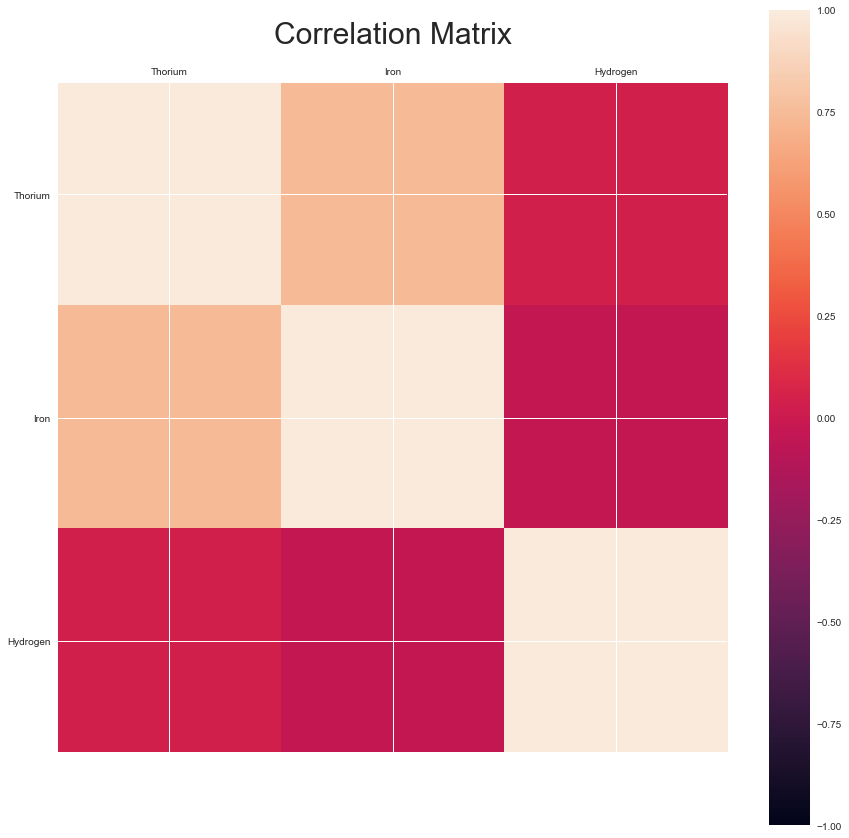

                mean   min     max
Thorium    22.192199   3.0   129.0
Iron       77.873765  26.0   266.0
Hydrogen  628.965235   0.0  1955.0


In [30]:
# function which gets the "value" columns from all dataframes passed and aggregates them into one dataframe 
def aggregateValues(listOfDataframes):
    for index, df in enumerate(listOfDataframes):
        if index == 0:
            valuesDf = df.iloc[:,2].copy()
            valuesDf = valuesDf.to_frame()
        else:
            valuesDf = pandas.concat([valuesDf, df.iloc[:,2].copy()], axis=1)
    return valuesDf


# input list of dataframes -> output dataframe of mean, std, min, and max depending on bool value passed for each
def getResults(listofDataframes, mean = False, std = False, min = False, max = False):
    valuesDf = aggregateValues(listofDataframes)
    description = valuesDf.describe()
# count  3.000000  3.000000  3.000000
# mean   0.595906  0.571440  0.335165
# std    0.498073  0.539181  0.576933
# min    0.039447 -0.033953 -0.033953
# 25%    0.393859  0.357159  0.002747
# 50%    0.748271  0.748271  0.039447
# 75%    0.874136  0.874136  0.519724
# max
    if mean:
        mean = description.iloc[1,:]
        resultsDF = mean.to_frame()
        
    if std:
        std = description.iloc[2,:]
        try:
          resultsDF
        except NameError:
          resultsDF = std.to_frame()
        else:
          resultsDF = pandas.concat([resultsDF, std], axis=1)
        
    if min:
        min = description.iloc[3,:]
        try:
          resultsDF
        except NameError:
          resultsDF = min.to_frame()
        else:
          resultsDF = pandas.concat([resultsDF, min], axis=1)
    if max:
        max = description.iloc[7,:]
        try:
          resultsDF
        except NameError:
          resultsDF = max.to_frame()
        else:
          resultsDF = pandas.concat([resultsDF, max], axis=1)
    return resultsDF
 

# input list of dataframes -> output dataframe which is a correlation matrix of dataframes passed 
def getCorrelation(listOfDataframes):
    valuesDf = aggregateValues(listOfDataframes)
    return valuesDf.corr()
 
def visualizeCorrelation(listOfDataframes):
    correlations = getCorrelation(listOfDataframes)
    fig = plt.figure(figsize=(15,15))
    plt.title("Correlation Matrix", fontsize= 30)
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = numpy.arange(0,3,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(correlations.columns)
    ax.set_yticklabels(correlations.columns)
    plt.show()

# print output of calls to functions
print(getCorrelation([df1,df2,df3]))
visualizeCorrelation([df1,df2,df3])
print(getResults([df1,df2,df3], mean = True, std = False, min = True, max = True))

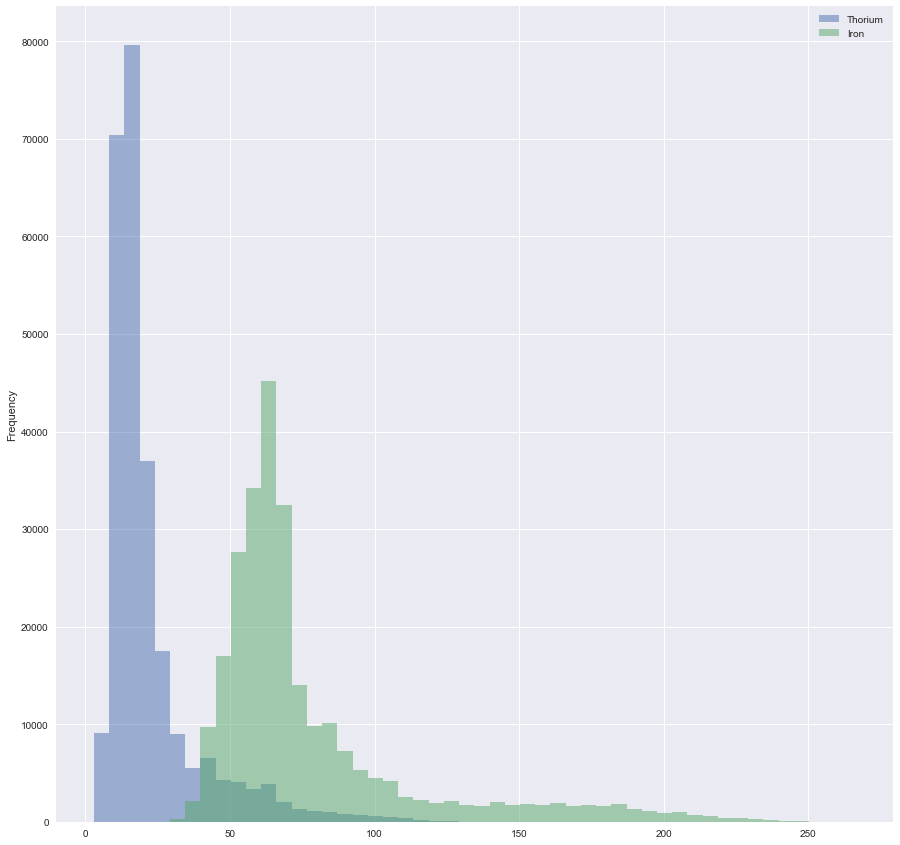

In [5]:
def plotHistogram(df):
    fig = plt.figure(figsize=(15,15))
    plt.xlabel('Value', fontsize= 20)
    plt.ylabel('Frequency', fontsize= 20)
    plt.title(df.columns.values.tolist()[-1], fontsize= 30)
    ax = fig.add_subplot(111)
    df = df.iloc[:,2].copy()
    ax = df.hist(figsize=(15,15), bins= 25)
    plt.show()
    
aggregateValues([df1,df2]).plot.hist(figsize=(15,15),alpha=0.5, bins=50)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


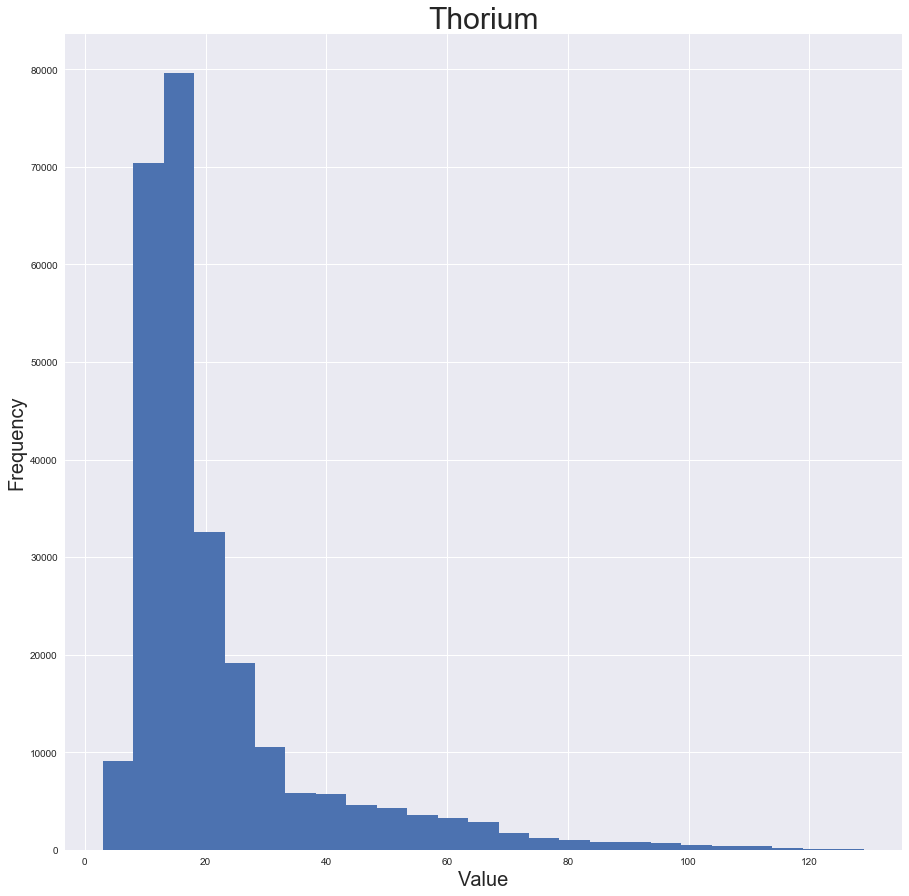

In [6]:
# plotting thorium
plotHistogram(df1)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


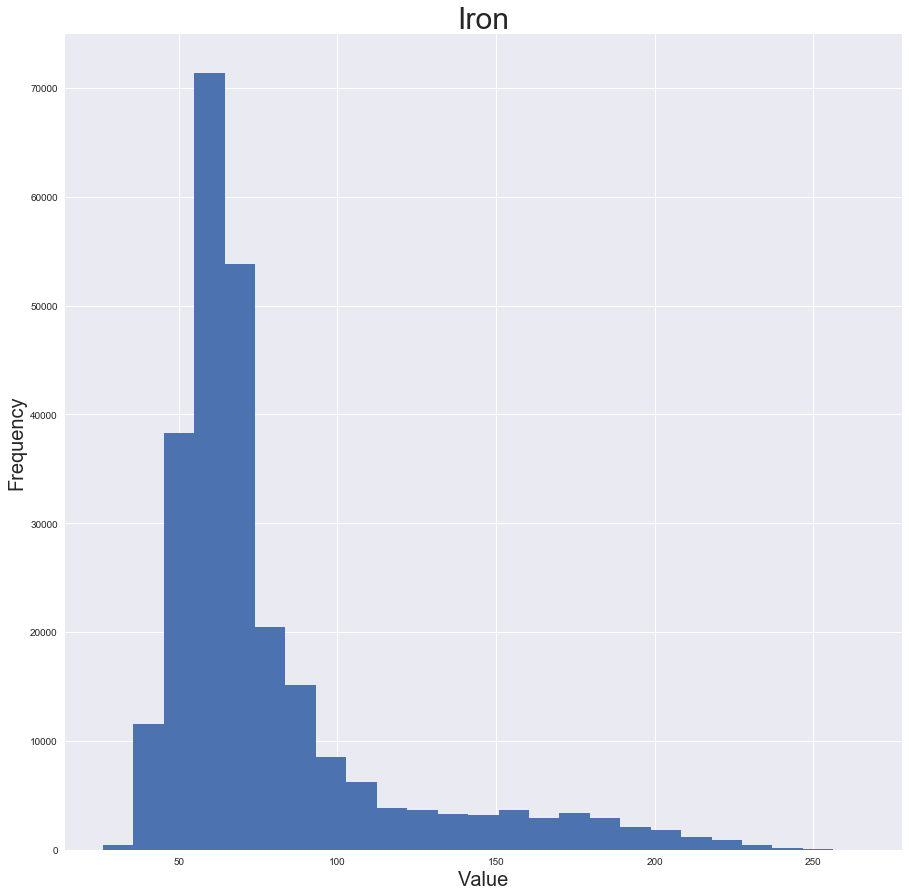

In [7]:
# plotting iron
plotHistogram(df2)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


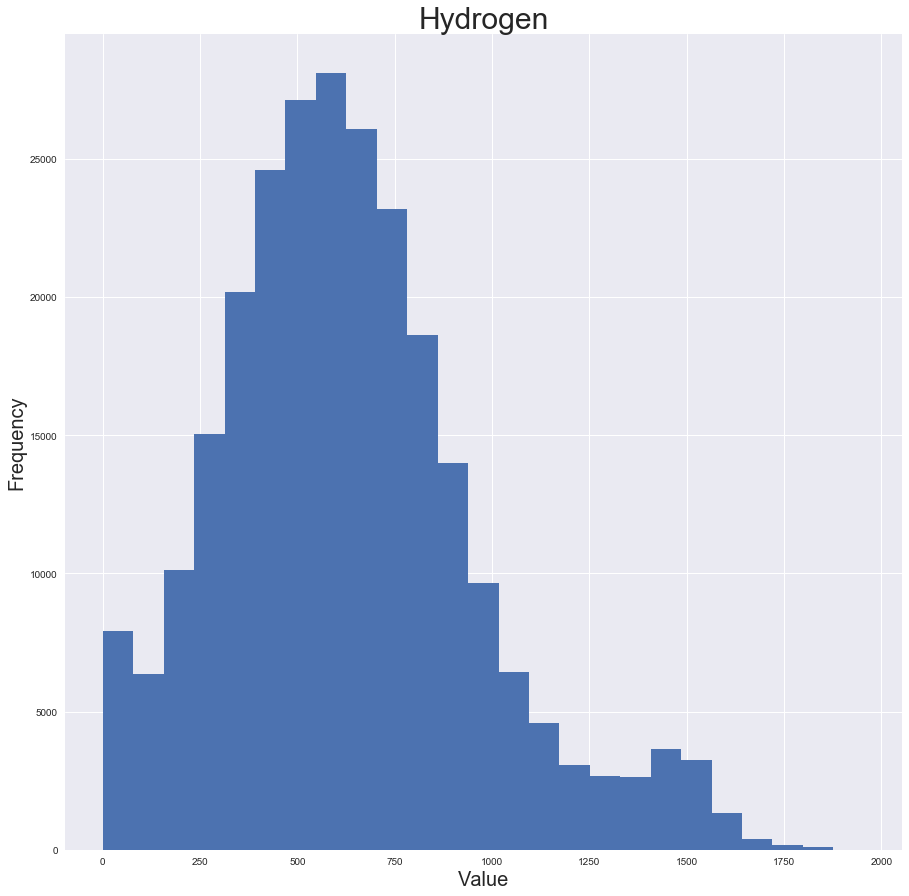

In [8]:
# plotting hydrogen
plotHistogram(df3)

In [9]:
# elements_dataframe.plot(kind = 'scatter', x ='Th', y='Fe', alpha = .6, color = 'red')
# plt.xlabel('Thorium')
# plt.ylabel('Iron')
# plt.title('Th vs Fe Scatter Plot')
# plt.show()

# sns.regplot(x="Th", y="Fe", data=elements_dataframe);

# elements_dataframe.plot(kind = 'scatter', x ='Th', y='H', alpha = .6, color = 'red')
# plt.xlabel('Thorium')
# plt.ylabel('Hydrogen')
# plt.title('Th vs H Scatter Plot')
# plt.show()

# sns.regplot(x="Th", y="H", data=elements_dataframe);

# elements_dataframe.plot(kind = 'scatter', x ='Fe', y='H', alpha = .6, color = 'red')
# plt.xlabel('Iron')
# plt.ylabel('Hydrogen')
# plt.title('Fe vs H Scatter Plot')
# plt.show()

# sns.regplot(x="Fe", y="H", data=elements_dataframe);

In [10]:
# covariance = elements_dataframe.cov()
# df_norm = (covariance - covariance.mean()) / (covariance.max() - covariance.min())
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(df_norm, vmin=-1, vmax=1)
# fig.colorbar(cax)

# ticks = numpy.arange(0,3,1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(elements_dataframe.columns)
# ax.set_yticklabels(elements_dataframe.columns)
# plt.show()

In [11]:
# x = covariance.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# normalized = pandas.DataFrame(x_scaled)
# print(normalized)

In [12]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(normalized, vmin=-1, vmax=1)
# fig.colorbar(cax)

# ticks = numpy.arange(0,3,1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(elements_dataframe.columns)
# ax.set_yticklabels(elements_dataframe.columns)
# plt.show()

In [13]:
resizedLola = gr.from_file("resizedLOLA.xyz").to_pandas()
resizedLola.head()

,row,col,value,x,y
0,0,0,-81.5,-180.0,90.0
1,0,1,-82.0,-179.5,90.0
2,0,2,-85.0,-179.0,90.0
3,0,3,-89.0,-178.5,90.0
4,0,4,-109.0,-178.0,90.0


In [14]:
resizedLola[(resizedLola.x == -10) & (resizedLola.y == -4)]

,row,col,value,x,y
135700,188,340,-1047.0,-10.0,-4.0


In [15]:
resizedLola.describe()

,row,col,value,x,y
count,259200.000000,259200.000000,259200.000000,259200.000000,259200.000000
mean,179.500000,359.500000,-519.058838,-0.250000,0.250000
std,103.922848,207.846297,2207.438477,103.923149,51.961424
min,0.000000,0.000000,-8542.500000,-180.000000,-89.500000
25%,89.750000,179.750000,-1909.500000,-90.125000,-44.625000
50%,179.500000,359.500000,-794.500000,-0.250000,0.250000
75%,269.250000,539.250000,633.500000,89.625000,45.125000
max,359.000000,719.000000,10176.500000,179.500000,90.000000


In [16]:
from pyproj import Proj, transform
def convertToLatLong(coordX, coordY):
    inProj = Proj(init='epsg:32662')
    outProj = Proj(init='epsg:4326')
    return transform(inProj,outProj,coordX,coordY)

test = df1.copy()
test['Latitude', 'Longitude'] = test.apply(lambda x: convertToLatLong(x['x'], x['y']), axis = 1)
test.head()

,x,y,Thorium,"(Latitude, Longitude)"
0,-5.458203e+06,2729101.54,17,"(-49.03187250592247, 24.515936252961236)"
1,-5.443041e+06,2729101.54,17,"(-48.895672860272306, 24.515936252961236)"
2,-5.427880e+06,2729101.54,17,"(-48.759473214622155, 24.515936252961236)"
3,-5.412718e+06,2729101.54,17,"(-48.62327356897199, 24.515936252961236)"
4,-5.397556e+06,2729101.54,17,"(-48.48707392332183, 24.515936252961236)"


In [17]:
test[['Lat','Long']] = test[test.columns[3]].apply(pandas.Series)
test['Lat'] = test['Lat'].astype(float)
test['Lat'] *= float(3.67109)
test['Long'] = test['Long'].astype(float)
test['Long'] *= float(3.67109)
test.head()

,x,y,Thorium,"(Latitude, Longitude)",Lat,Long
0,-5.458203e+06,2729101.54,17,"(-49.03187250592247, 24.515936252961236)",-180.000417,90.000208
1,-5.443041e+06,2729101.54,17,"(-48.895672860272306, 24.515936252961236)",-179.500416,90.000208
2,-5.427880e+06,2729101.54,17,"(-48.759473214622155, 24.515936252961236)",-179.000415,90.000208
3,-5.412718e+06,2729101.54,17,"(-48.62327356897199, 24.515936252961236)",-178.500413,90.000208
4,-5.397556e+06,2729101.54,17,"(-48.48707392332183, 24.515936252961236)",-178.000412,90.000208


In [18]:
test.dtypes

x                        float64
y                        float64
Thorium                   uint16
(Latitude, Longitude)     object
Lat                      float64
Long                     float64
dtype: object

In [20]:
test[['Lat','Long']] = test[test.columns[3]].apply(pandas.Series)

In [22]:
lola_latlong = test[['Lat', 'Long', 'Thorium']].copy()

In [23]:
lola_latlong.Lat = lola_latlong.Lat.round()
lola_latlong.Long = lola_latlong.Long.round()

In [27]:
lola_values = lola_latlong['Thorium']
lola_values.name = 'Elevation'
allTif = pandas.concat([aggregateValues([df1,df2,df3]), resizedLola.value], axis = 1)

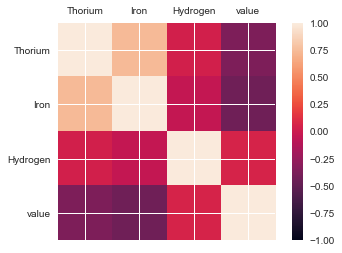

In [28]:
correlations = allTif.corr()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = numpy.arange(0,4,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(allTif.columns)
ax.set_yticklabels(allTif.columns)
plt.show()
# fig.savefig('corr.png', bbox_inches='tight')

In [29]:
print(correlations)

           Thorium      Iron  Hydrogen     value
Thorium   1.000000  0.748271  0.039447 -0.365313
Iron      0.748271  1.000000 -0.033953 -0.428598
Hydrogen  0.039447 -0.033953  1.000000  0.063131
value    -0.365313 -0.428598  0.063131  1.000000
